## Problem Statement

This kernel focuses on solving a sales forecasting business problem as described by the [Predict Future Sales](https://www.kaggle.com/c/competitive-data-science-predict-future-sales) competition. 

As per the competition overview page:
> *In this competition you will work with a challenging time-series dataset consisting of daily sales data, kindly provided by one of the largest Russian software firms - 1C Company.* 

>*We are asking you to predict total sales for every product and store in the next month. By solving this competition you will be able to apply and enhance your data science skills.*

Let's get to it then!

## Imports

In [228]:
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
from math import sqrt

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

from matplotlib import style
style.use('seaborn')

import os
print(os.listdir("../input"))

%matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format

['items.csv', 'sample_submission.csv', 'test.csv', 'sales_train.csv', 'item_categories.csv', 'shops.csv']


## Getting the Data

In [229]:
PATH = '../input/'

**Training set**

In [230]:
sales = pd.read_csv(PATH + 'sales_train.csv', low_memory=False); sales.tail()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2935844,10.10.2015,33,25,7409,299.00,1.00
2935845,09.10.2015,33,25,7460,299.00,1.00
2935846,14.10.2015,33,25,7459,349.00,1.00
2935847,22.10.2015,33,25,7440,299.00,1.00
2935848,03.10.2015,33,25,7460,299.00,1.00


In [231]:
sales.describe(include="all")

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2935849,"2,935,849.00","2,935,849.00","2,935,849.00","2,935,849.00","2,935,849.00"
unique,1034,nan,nan,nan,nan,nan
top,28.12.2013,nan,nan,nan,nan,nan
freq,9434,nan,nan,nan,nan,nan
mean,NaN,14.57,33.00,"10,197.23",890.85,1.24
std,NaN,9.42,16.23,"6,324.30","1,729.80",2.62
min,NaN,0.00,0.00,0.00,-1.00,-22.00
25%,NaN,7.00,22.00,"4,476.00",249.00,1.00
50%,NaN,14.00,31.00,"9,343.00",399.00,1.00
75%,NaN,23.00,47.00,"15,684.00",999.00,1.00


In [232]:
items = pd.read_csv(PATH + 'items.csv', low_memory=False, index_col=1); items.head()

,item_name,item_category_id
item_id,,
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,40
1,!ABBYY FineReader 12 Professional Edition Full...,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,40
4,***КОРОБКА (СТЕКЛО) D,40


In [233]:
item_cat = pd.read_csv(PATH + 'item_categories.csv', low_memory=False, index_col=1); item_cat.head()

,item_category_name
item_category_id,
0,PC - Гарнитуры/Наушники
1,Аксессуары - PS2
2,Аксессуары - PS3
3,Аксессуары - PS4
4,Аксессуары - PSP


In [234]:
shops = pd.read_csv(PATH + 'shops.csv', low_memory=False, index_col=1); shops.head()

,shop_name
shop_id,
0,"!Якутск Орджоникидзе, 56 фран"
1,"!Якутск ТЦ ""Центральный"" фран"
2,"Адыгея ТЦ ""Мега"""
3,"Балашиха ТРК ""Октябрь-Киномир"""
4,"Волжский ТЦ ""Волга Молл"""


The above dataset is an example of a [star schema](https://en.wikipedia.org/wiki/Star_schema), with **sales** being the *fact table* and the rest of our imported datasets being the *dimension tables*.

 **Test set**

Let's import the test set for the competition:

In [235]:
test = pd.read_csv(PATH + 'test.csv', low_memory=False, index_col=0); test.head()

,shop_id,item_id
ID,,
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268


Only the `shop_id` and `item_id` are provided in the test set. As per the competition rules, we are looking for total number of items sold per shop. In order to obtain this data we will need to convert our daily training dataset into a monthly aggregate.

It's worth noting the combination of particular item and the shop it is being sold in defines a unique combination we are asked to forecast. Let's check if the training data we have allows us to infer the values for all unique combinations in the test set. To make the calculation easier, we'll define a unique key which will simply be a concatenation of the item and shop id's:

In [236]:
def assign_key(df): df['key'] = df['item_id'].astype('int32').map(str) + "_" + df['shop_id'].astype('int32').map(str)
    
assign_key(sales)
assign_key(test)

In [237]:
test['key'][~test['key'].isin(sales['key'])].shape[0] / test['key'].shape[0]

0.479906629318394

Almost half of the combinations we are asked to forecast have never been observed in the training data - i.e. these shops never sold that particular item. This is an important realisation as we may need to amend our dataset to allow the model to correctly infer whenever this is the case.

For completeness, we check if all the shops and items from the test set are observed in the training set:

In [238]:
test['item_id'][~test['item_id'].isin(sales['item_id'])].drop_duplicates().shape[0]

363

In [239]:
test['shop_id'][~test['shop_id'].isin(sales['shop_id'])].shape[0]

0

Looks like 363 item id's vere never reported in our training data - again, something to take note of during feature engineering.

**Initial glance at the data**

To have an idea of what we're up against, let's look at the monthly aggregates of number of items sold  (`item_cnt_day` - which will be our dependent variable in the modelling section) and plot it over the analysed months (`date_block_num`):

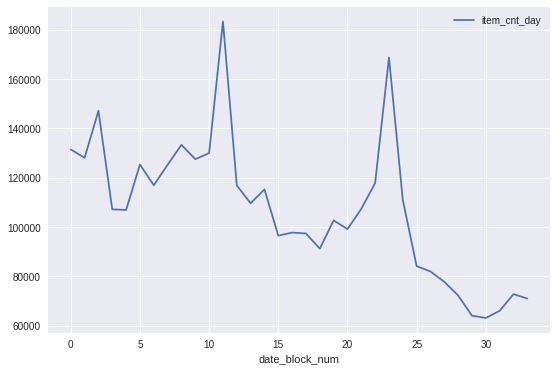

In [240]:
sales[['date_block_num', 'item_cnt_day']].groupby('date_block_num').sum().plot(figsize=(9, 6))
plt.show()

Seasonal spikes in December is something that is immediately apparent - most likely due to Christmas sales. This is certainly something to take note of for feature engineering.

Speaking of which...

## Feature Engineering

**Combining the dataset**

Since this is a structured data problem, we need to follow some feature engineering steps before we apply a model to get our predictions. First of all, let's combine out star schema into a single table.

In [241]:
df = sales.copy()
test_set = test.copy()

We have three dimension tables supplied. Looking at them in turns, we note that:
1. `shops` only contains the name of the shop which is irrelevant to our problem - we will therefore omit importing it into our dataset
1. `items` has item names that are also irrelevant to the problem. However, it also holds the item category id which might prove to be relevant - that's something we definitely want to keep
1. `item_cat` only holds category name - similar story as with `shops`

This means we only want to merge part of the `items` table with our dataset - and the test set too, using the occasion:

In [242]:
df = df.merge(items[['item_category_id']], how='left', on='item_id')
test_set = test_set.merge(items[['item_category_id']], how='left', on='item_id')
test_set.index.rename('ID', inplace=True)

It's worth checking if we introduced any unwanted duplication in our dataset: 

In [243]:
sales.shape[0] == df.shape[0], test_set.shape[0] == test.shape[0]

(True, True)

In [244]:
df.columns, test.columns

(Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
        'item_cnt_day', 'key', 'item_category_id'],
       dtype='object'), Index(['shop_id', 'item_id', 'key'], dtype='object'))

Looks like everything went fine.

**Missing values check**

Now let's check for missing values in the combined dataset and the test set:

In [245]:
df.isna().sum(), test.isna().sum()

(date                0
 date_block_num      0
 shop_id             0
 item_id             0
 item_price          0
 item_cnt_day        0
 key                 0
 item_category_id    0
 dtype: int64, shop_id    0
 item_id    0
 key        0
 dtype: int64)

So far so good!

**Parsing the date**

As we've seen on the plot earlier, it is very likely seasonality is affecting the monthly sales. This means there is potentially valuable information in the date field - and that is what we are now going to extract into additional features using Pandas built in features:

In [246]:
df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y')

We will be reducing the final dataset to monthly aggregates eventually but for now, we also extract information like week and day number to calculate the number of weeks and days in a month as these may also prove to have impact on the number of sales in a month:

In [247]:
attr = ['year', 'month', 'week', 'day']

for a in attr: df[a] = getattr(df['date'].dt, a)

In [248]:
df.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day', 'key', 'item_category_id', 'year', 'month', 'week',
       'day'],
      dtype='object')

Now, let's add the number of weeks and number of days in a month. For this purpose, we will use the provided `date_block_num` which simply indicates the consecutive month number counting from the start of the analysed period:

In [249]:
d = df[['date_block_num', 'day']].groupby(['date_block_num']).max()
di = dict([(d.index[i], d.values[i][0]) for i in range(len(d))])
df['day_count'] = df['date_block_num'].map(di)

In [250]:
df.loc[((df['week'] == 1) & (df['day'] > 7)), 'week'] = 53
df['week_block_num'] = (df['year'] - df['year'].min()) * 52 + df['week']

wmax = df[['date_block_num', 'week_block_num']].groupby(['date_block_num']).max()
wmin = df[['date_block_num', 'week_block_num']].groupby(['date_block_num']).min()
di = dict([(wmax.index[i], wmax.values[i][0] - wmin.values[i][0]) for i in range(len(wmax))])
df['week_count'] = df['date_block_num'].map(di)

Given the potential seasonality in the data, we will also add indicator variables for quarters of the year and Christmas time:

In [251]:
df['qtr'] = df['month'].map(dict([[i, int(i // 3.1 + 1)] for i in df['month'].unique()]))

In [252]:
df['x_mas'] = df['month'].map(dict([[i, i // 12] for i in df['month'].unique()]))

**Dataset aggregation**

Now it's time to group the dataset into monthly aggregates. Let's look at the current set of features:

In [253]:
df.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day', 'key', 'item_category_id', 'year', 'month', 'week',
       'day', 'day_count', 'week_block_num', 'week_count', 'qtr', 'x_mas'],
      dtype='object')

In order to aggregate the dataset, we need to understand which features will need to be grouped:

In [254]:
to_group = ['date_block_num', 'shop_id', 'item_id', 'key', 'item_category_id',
            'year', 'month', 'day_count', 'week_count', 'qtr', 'x_mas']

We also want to take the average price in a month in case there was a price change intra month:

In [255]:
to_mean = ['item_price']

Finally, we want to summarise the sold units which are going to be our dependant variable in the model later on:

In [256]:
to_sum = ['item_cnt_day']

Now, time to make things happen!

In [257]:
da = df[to_group].copy()
da = pd.concat([da,
                df[to_group + to_mean].groupby(to_group).transform('mean'),
                df[to_group + to_sum].groupby(to_group).transform('sum'),
               ], axis=1).drop_duplicates()
da.rename(columns={'item_cnt_day': 'item_cnt_month'}, inplace=True)
da.head()

,date_block_num,shop_id,item_id,key,item_category_id,year,month,day_count,week_count,qtr,x_mas,item_price,item_cnt_month
0,0,59,22154,22154_59,37,2013,1,31,4,1,0,999.00,1.00
1,0,25,2552,2552_25,58,2013,1,31,4,1,0,899.00,0.00
3,0,25,2554,2554_25,58,2013,1,31,4,1,0,"1,709.05",1.00
4,0,25,2555,2555_25,56,2013,1,31,4,1,0,"1,099.00",1.00
5,0,25,2564,2564_25,59,2013,1,31,4,1,0,349.00,1.00


In [258]:
da.describe(include='all')

,date_block_num,shop_id,item_id,key,item_category_id,year,month,day_count,week_count,qtr,x_mas,item_price,item_cnt_month
count,"1,609,124.00","1,609,124.00","1,609,124.00",1609124,"1,609,124.00","1,609,124.00","1,609,124.00","1,609,124.00","1,609,124.00","1,609,124.00","1,609,124.00","1,609,124.00","1,609,124.00"
unique,nan,nan,nan,424124,nan,nan,nan,nan,nan,nan,nan,nan,nan
top,nan,nan,nan,2252_31,nan,nan,nan,nan,nan,nan,nan,nan,nan
freq,nan,nan,nan,34,nan,nan,nan,nan,nan,nan,nan,nan,nan
mean,14.66,32.81,"10,680.99",NaN,41.54,"2,013.79",6.15,30.42,4.18,2.39,0.08,790.88,2.27
std,9.54,16.54,"6,238.88",NaN,16.32,0.78,3.46,0.89,0.38,1.12,0.27,"1,551.61",8.65
min,0.00,0.00,0.00,NaN,0.00,"2,013.00",1.00,28.00,4.00,1.00,0.00,0.09,-22.00
25%,6.00,21.00,"5,045.00",NaN,30.00,"2,013.00",3.00,30.00,4.00,1.00,0.00,199.00,1.00
50%,14.00,31.00,"10,497.00",NaN,40.00,"2,014.00",6.00,31.00,4.00,2.00,0.00,399.00,1.00
75%,23.00,47.00,"16,060.00",NaN,55.00,"2,014.00",9.00,31.00,4.00,3.00,0.00,898.50,2.00


**Missing item-shop combinations**

As we've seen previously, not all item-shop combinations that we are supposed to infer upon are available in our dataset. To allow our model to learn from these missing observations as well, we'll append the dataset to include them.

Such observations will also need an item price assigned. As an assumption, we will use the average item price up to that point in time:

In [259]:
test_set.columns

Index(['shop_id', 'item_id', 'key', 'item_category_id'], dtype='object')

In [260]:
avg_prices = pd.concat((da[['date_block_num', 'item_id']], da[['date_block_num', 'item_id','item_price']]
                        .groupby(['date_block_num', 'item_id'])
                        .transform('mean')), axis=1).sort_values(by=['date_block_num', 'item_id']).drop_duplicates().sort_values(by=['item_id', 'date_block_num'], ascending=False)

for m in da['date_block_num'].unique():
    mask = ~test_set['key'].isin(da['key'][da['date_block_num'] == m])
    mask2 = (da['date_block_num'] == m)
    
    md = test_set[['key', 'shop_id', 'item_id', 'item_category_id']][mask]
    md['date_block_num'] = m
    for col in ['year', 'month', 'day_count', 'week_count', 'qtr', 'x_mas']: md[col] = da[col][mask2].max()
    
    avg = avg_prices[avg_prices['date_block_num'] <= m].drop(columns='date_block_num').groupby('item_id').mean()
    md['item_price'] = md['item_id'].map(dict(zip(avg.index, avg.values[:, 0]))).fillna(0)
    md['item_cnt_month'] = 0
    
    da = da.append(md, ignore_index=True, sort=True)

For extra level of verification, let's compare the monthly number of items sold (`item_cnt_day`) and the monthly sales (`item_cnt_day` times `item_price`) per the original imported dataset and our aggregated set:

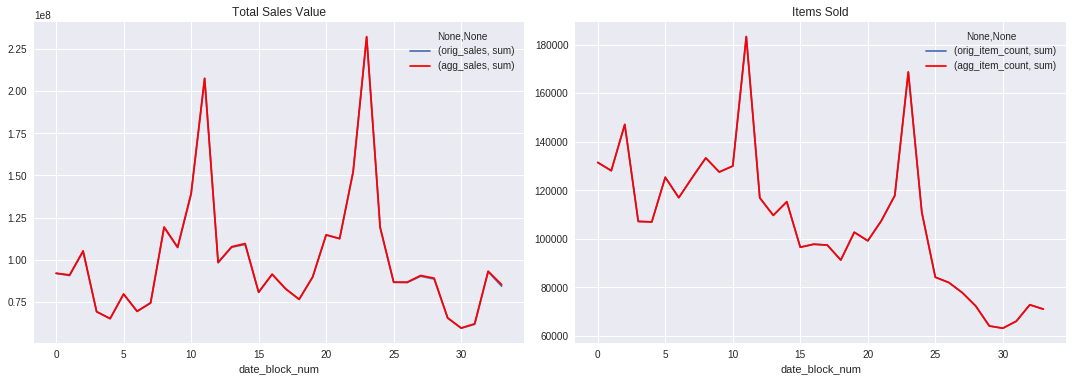

In [261]:
s_ch = sales.copy()
s_ch["orig_sales"] = s_ch["item_price"] * s_ch["item_cnt_day"]
s_ch["orig_item_count"] = s_ch["item_cnt_day"]

a_ch = da.copy()
a_ch["agg_sales"] = a_ch["item_price"] * a_ch["item_cnt_month"]
a_ch["agg_item_count"] = a_ch["item_cnt_month"]

fig = plt.figure(figsize=(15, 10))
ax1 = plt.subplot2grid((2, 2), (0, 0))
ax2 = plt.subplot2grid((2, 2), (0, 1))

s_ch[["date_block_num", "orig_sales"]].groupby("date_block_num").agg([sum]).plot(legend=True, ax=ax1, title="Total Sales Value")
s_ch[["date_block_num", "orig_item_count"]].groupby("date_block_num").agg([sum]).plot(legend=True, ax=ax2, title="Items Sold")

a_ch[["date_block_num", "agg_sales"]].groupby("date_block_num").agg([sum]).plot(legend=True, ax=ax1, color='r')
a_ch[["date_block_num", "agg_item_count"]].groupby("date_block_num").agg([sum]).plot(legend=True, color='r', ax=ax2)


plt.tight_layout()
plt.show()

As we expected, the plots match!



**Lagged Features**

Past sales performance can often be a very good indicator of how good our business will be looking in the future. To verify that this is also the case for 1C shops, we will introduce some lagged features into the mix. 

In an annual sales cycle, choosing last month, last quarter and last year sales sounds like a reasonable choice. Let us define these features then:

In [262]:
da['prev_month'] = da['date_block_num'].map(dict([[i, i-1] if i > 0 else [i, np.nan] for i in df['date_block_num'].unique()]))
da['prev_qtr'] = da['date_block_num'].map(dict([[i, i-3] if i > 2 else [i, np.nan] for i in df['date_block_num'].unique()]))
da['prev_year'] = da['date_block_num'].map(dict([[i, i-12] if i > 11 else [i, np.nan] for i in df['date_block_num'].unique()]))

In [263]:
di = dict(zip(da['date_block_num'].astype('float32').map(str) + da['key'].values, da['item_cnt_month']))

def prev_sales(prevsale, prevperiod): 
    da[prevsale] = (da[prevperiod].map(str) + da['key']).map(di).fillna(0)
    da.drop(columns=prevperiod, inplace=True)

prev_sales('item_cnt_prevm', 'prev_month')
prev_sales('item_cnt_prevq', 'prev_qtr')
prev_sales('item_cnt_prevy', 'prev_year')

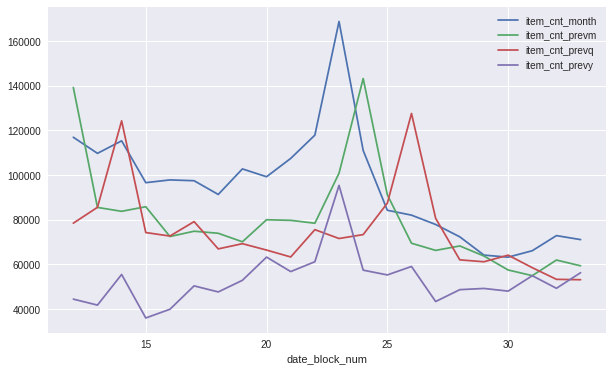

In [264]:
da[['date_block_num','item_cnt_month', 'item_cnt_prevm', 'item_cnt_prevq', 'item_cnt_prevy']][da['date_block_num'] > 11].groupby(['date_block_num']).sum().plot(figsize=(10, 6))
plt.show()

We note that the previous month sales fall beneath the the numbers we've actually observed in the past. This is because there are some shop-item combinations in the training set that are not present in the test set - we did not fill in the missing values for these. If we look at the same plot for only the combinations available in the test set, we see the expected output:

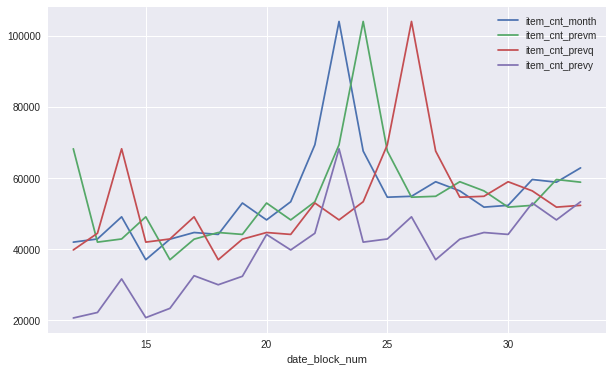

In [265]:
da[['date_block_num','item_cnt_month', 'item_cnt_prevm', 'item_cnt_prevq', 'item_cnt_prevy']][(da['key'].isin(test['key'])) & (da['date_block_num'] > 11)].groupby(['date_block_num']).sum().plot(figsize=(10, 6))
plt.show()

**Adding missing features to the test set**

Since we have our additional features created for modelling purposes, it is worth creating them in the test set as well to allow forecasting from the model later on:

In [266]:
price_map = dict(da[['key', 'item_price']][da['date_block_num'] == da['date_block_num'].max()].values)
test_set['item_price'] = test_set['key'].map(price_map).fillna(0)
test_set['date_block_num'] = da['date_block_num'].max() + 1
test_set['year'] = 2015
test_set['month'] = 11
test_set['day_count'] = 30
test_set['week_count'] = 4
test_set['qtr'] = 4
test_set['x_mas'] = 0
lags = [['item_cnt_prevm', 0], ['item_cnt_prevq', 2], ['item_cnt_prevy', 11]]
for l in lags: test_set[l[0]] = test_set['key'].map(dict(da[['key', 'item_cnt_month']][(da['date_block_num'] == da['date_block_num'].max() - l[1])].values))

## Modelling

**Validation and Training sets**

We are dealing with a temporal problem here. This means random sampling for model validation purposes is not the best idea.

As a reminder, we are supposed to forecast the sales for the next month, which means November 2015, since the last month reported in our dataset is October 2015:

In [267]:
da[['year', 'month']][da['year']==da['year'].max()].max()

year     2015
month      10
dtype: int64

Therefore, setting October 2015 observations as our validation set for model training seems to be a good choice. 

As for the data we will use for training, for computational purposes we will limit it to the last year (luckily, our lagged features will still hold some information on the previous periods).

In [268]:
to_val = (da['date_block_num'] == da['date_block_num'].max())
to_train = (da['date_block_num'] > da['date_block_num'].max() - 12) & (da['date_block_num'] != da['date_block_num'].max())

X_train = da[to_train].drop(columns=['item_cnt_month', 'date_block_num', 'key'])
X_val = da[to_val].drop(columns=['item_cnt_month', 'date_block_num', 'key'])

As for our dependant variable, we will train the model on log of monthly item count, rather than the level itself - this way are able to address the positive skew of the distribution that is mostly comprising  zeros.

In [269]:
da['item_cnt_month'].skew()

146.66675180100336

We will also clip the item count values to range between 0 and 20, as per the competition rules:

In [270]:
y_train = np.log1p(da['item_cnt_month'][to_train].clip(0., 20.))
y_val = np.log1p(da['item_cnt_month'][to_val].clip(0., 20.))

In [271]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, da.shape

((2502889, 13), (2502889,), (217051, 13), (217051,), (8291765, 16))

## Modelling

We start off by defining the evaluation metric which, as per the competition rules, is RMSE (Root Mean Squared Error):

In [272]:
def RMSE(targ, pred): return np.sqrt(np.mean((np.expm1(targ) - np.expm1(pred))**2))

We will use a random forest regressor to deal with this problem:

In [273]:
from sklearn.ensemble import RandomForestRegressor

In [274]:
def review(X_train, X_val):
    m.fit(X_train, y_train)
    preds = m.predict(X_val)
    print("-"*30, f'''
    Training score: {m.score(X_train, y_train)*100:.2f}%
    Validation score: {m.score(X_val, y_val)*100:.2f}%
    Out-of-Bag score: {m.oob_score_*100:.2f}%
    RMSE: {RMSE(y_val, preds):.4f}
    ''')

In [275]:
%%time
m = RandomForestRegressor(n_estimators=50, max_features=0.85, min_samples_leaf=5,
                          n_jobs=-1, oob_score=True)

review(X_train, X_val)

------------------------------ 
    Training score: 87.13%
    Validation score: 52.20%
    Out-of-Bag score: 77.52%
    RMSE: 0.9369
    
CPU times: user 16min 22s, sys: 1.31 s, total: 16min 23s
Wall time: 4min 32s


**Feature Importance**

Let's review which features have the biggest predictive power:

In [276]:
def f_i(X_train, X_val, use_RMSE=False):
    global FI
    accs = []
    if use_RMSE:
        targ = RMSE(m.predict(X_train), y_train)
    else:
        targ = m.score(X_train, y_train) 
    num_features = 15

    for c in X_train.columns:
        X = X_train.copy()
        X[c] = X[[c]].sample(frac=1).set_index(X.index)[c]  # random shuffle of one column
        if use_RMSE: 
            accs.append(RMSE(m.predict(X), y_train) - targ)
        else: 
            accs.append(targ - m.score(X, y_train))


    FI = sorted([[c, float(a)] for c, a in zip(X.columns, accs)], key=lambda x: x[1], reverse=True)[:num_features]
    pd.DataFrame({'Score loss': [FI[i][1] for i in range(len(FI))], 'Features': [FI[i][0] for i in range(len(FI))]}).set_index('Features').sort_values(by='Score loss', ascending=True).plot.barh()
    plt.show()

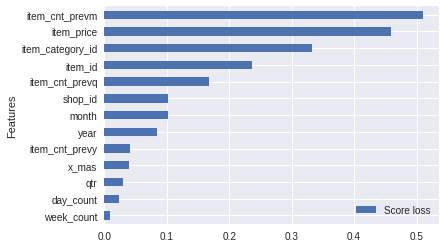

In [277]:
f_i(X_train, X_val, use_RMSE=True)

The previous month sales, item price and item category are among the most important features according to our model.

Let's see if  we can get comparable predictions with just the main predictors as per the above chart:

In [278]:
top = -2
selected = [FI[i][0] for i in range(len(FI))][:top]
Xt = X_train[selected].copy()
Xv = X_val[selected].copy()

In [279]:
%%time
m = RandomForestRegressor(n_estimators=50, max_features=0.85, min_samples_leaf=5,
                          n_jobs=-1, oob_score=True)
review(Xt, Xv)

------------------------------ 
    Training score: 86.96%
    Validation score: 50.44%
    Out-of-Bag score: 77.44%
    RMSE: 0.9387
    
CPU times: user 14min 37s, sys: 1.2 s, total: 14min 38s
Wall time: 4min 6s


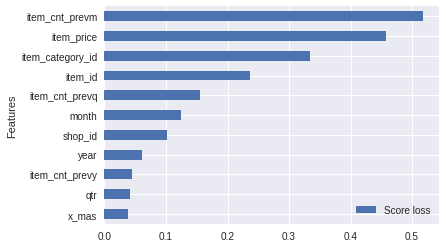

In [280]:
f_i(Xt, Xv, use_RMSE=True)

RMSE has slightly improved as a result, we'll use this specification of the model for the final output then.

Let's plot the results in a similar fashion as before:

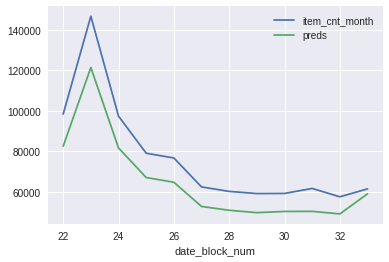

In [281]:
tp = da[['date_block_num', 'item_cnt_month']][to_train]
tp['item_cnt_month'].clip(0., 20., inplace=True)
tp['preds'] = np.expm1(m.predict(Xt))
pd.concat((tp['date_block_num'], tp.groupby('date_block_num').transform('sum')), axis=1).drop_duplicates().append(
    {'date_block_num': 33,'item_cnt_month': da['item_cnt_month'][da['date_block_num'] == da['date_block_num'].max()]
     .clip(0., 20.).sum(), 'preds': np.expm1(m.predict(Xv)).sum()}, ignore_index=True).groupby('date_block_num').sum().plot()
plt.show()

Our results seem to be underestimated, most likely due to log translation of clipped values. Otherwise, the model appears to be doing a reasonable job at forecasting October values.

**Final model**

Now that we have satisfactory results on the validation set, we will retrain the model with the October data included. This will allow us to use the most up to date information when forecasting November.

In [282]:
mask = (da['date_block_num'] > da['date_block_num'].max() - 12)
X_train = da[selected][mask]
# X_train = da.drop(columns=['item_cnt_month', 'date_block_num', 'key'])[mask]
y_train = np.log1p(da['item_cnt_month'].clip(0., 20.))[mask]

In [283]:
%%time
m = RandomForestRegressor(n_estimators=50, max_features=0.85, min_samples_leaf=5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print("-"*30, f'''
Training score: {m.score(X_train, y_train)*100:.2f}%
RMSE: {RMSE(m.predict(X_train), y_train):.4f}
''')

------------------------------ 
Training score: 86.73%
RMSE: 0.6361

CPU times: user 18min 20s, sys: 1.88 s, total: 18min 22s
Wall time: 5min 4s


Time to get the final results:

In [284]:
X_test = test_set[selected]
# X_test = test_set.drop(columns=['date_block_num', 'key'])
y_test = np.expm1(m.predict(X_test))

Let's review our November predictions in comparison to the previous months for a sense check of our predictions:

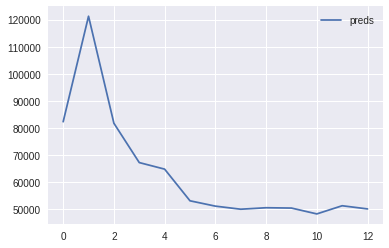

In [285]:
tp = da[['date_block_num']][mask]
tp['preds'] = np.expm1(m.predict(X_train))
tp = tp.groupby('date_block_num').transform('sum').drop_duplicates()
tp.append({'preds': sum(y_test)}, ignore_index=True).plot()
plt.show()

Looks reasonable, at least on a monthly aggregate level.

**Submission**

The only step left now is to create the final submission:

In [286]:
test_set['item_cnt_month'] = y_test

In [287]:
name = 'submission_v4.csv'
my_submission = test_set[['item_cnt_month']].clip(0., 20.)
my_submission.to_csv(name)

In [288]:
pd.read_csv(name).head()

,ID,item_cnt_month
0,0,0.45
1,1,0.00
2,2,1.04
3,3,0.16
4,4,0.00
